### Notebook for the mapping of cell populations to the 10X LV public data.

- Developed by Carlos Talavera-López Ph.D, WSI
- Version: 210211

Here we will apply the 'scVI-Stereoscope' workflow to map the adult heart cell atlas data from [Litviňuková et al 2020](https://www.nature.com/articles/s41586-020-2797-4). This experiment takes 24 minutes to run on Colab.  

You can access the raw count matrices as 'anndata' objects at www.heartcellatlas.org.

### Setting up `scVI`+`stereoscope` working environment.  

In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@stereoscope_lit#egg=scvi-tools[tutorials]

In [2]:
!pip install rich
!pip install scikit-misc --force

  Using cached https://files.pythonhosted.org/packages/e5/a9/7e539368f6a3c7cc071481fad9872825b174cd86408be40bd8b286d3977c/scikit_misc-0.1.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/14/32/d3fa649ad7ec0b82737b92fefd3c4dd376b0bb23730715124569f38f3a08/numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: pytorch-lightning 1.1.8 has requirement future>=0.17.1, but you'll have future 0.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: scikit-misc 0.1.3
    Uninstalling scikit-misc-0.1.3:
      Successfully uninstalled scikit-misc-0.1.3


- Access data in `GDrive` 

In [3]:
%matplotlib inline
%load_ext autoreload

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Import your GDrive to work on CoLab. 

- One of the cool things of Colab is that you can use your GDrive to load your own data. 

- The command below mounts your GDrive directory to your CoLab node. If you want to learn more avout that, visit [here](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166). 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- Import required packages

In [6]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from fbpca import pca
from geosketch import gs
import matplotlib.pyplot as plt
from scvi.data import register_tensor_from_anndata
from scvi.external.stereoscope import RNAStereoscope, SpatialStereoscope

In [7]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 200, vector_friendly = True, format = 'svg')

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 7.0.0
absl                NA
anndata             0.7.5
astor               0.8.1
autoreload          NA
bottleneck          1.3.2
certifi             2020.12.05
cffi                1.14.4
chardet             3.0.4
cloudpickle         1.3.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2.12.0
dataclasses         NA
dateutil            2.8.1
decorator           4.4.2
fbpca               NA
fsspec              0.8.5
geosketch           1.2
get_version         2.1
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.3
importlib_metadata  1.7.0
ipykernel           4.10.1
ipython_genutils    0.2.0
ipywidgets          7.6.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.34.0
matplotlib          3.2.2
mpl_toolkits        NA
natsort        

### Read in visium data.

- This is the Left Ventricle dataset that 10X Genomics has made available in theri [website](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Human_Heart). 

In [8]:
adata = sc.read_visium('/content/gdrive/My Drive/colab/data/visium/10x_lv/', genome = 'GRCh38', count_file = 'V1_Human_Heart_filtered_feature_bc_matrix.h5', load_images = True)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
adata

reading /content/gdrive/My Drive/colab/data/visium/10x_lv/V1_Human_Heart_filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4235 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

- Clean up data based on QC values

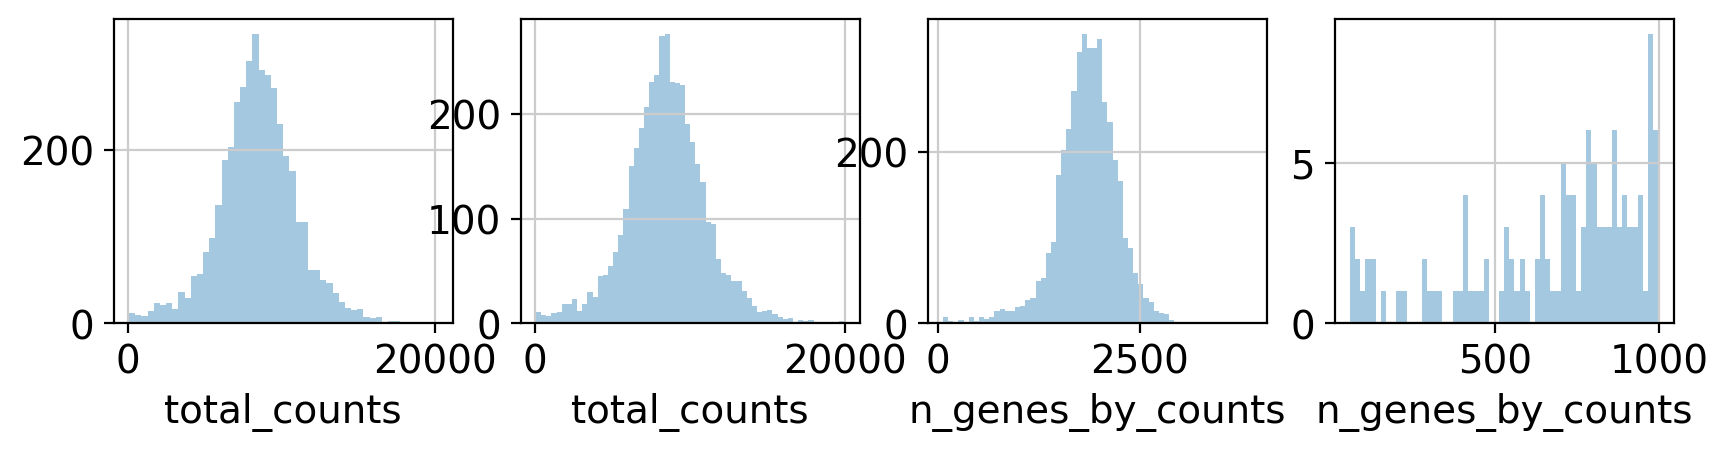

In [9]:
fig, axs = plt.subplots(1, 4, figsize = (10, 2))
sns.distplot(adata.obs["total_counts"], kde = False, ax = axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 20000], kde = False, bins = 60, ax = axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde = False, bins = 60, ax = axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde = False, bins = 60, ax = axs[3])

filtered out 13 cells that have less than 500 counts
filtered out 16 cells that have less than 500 genes expressed
... storing 'feature_types' as categorical
... storing 'genome' as categorical


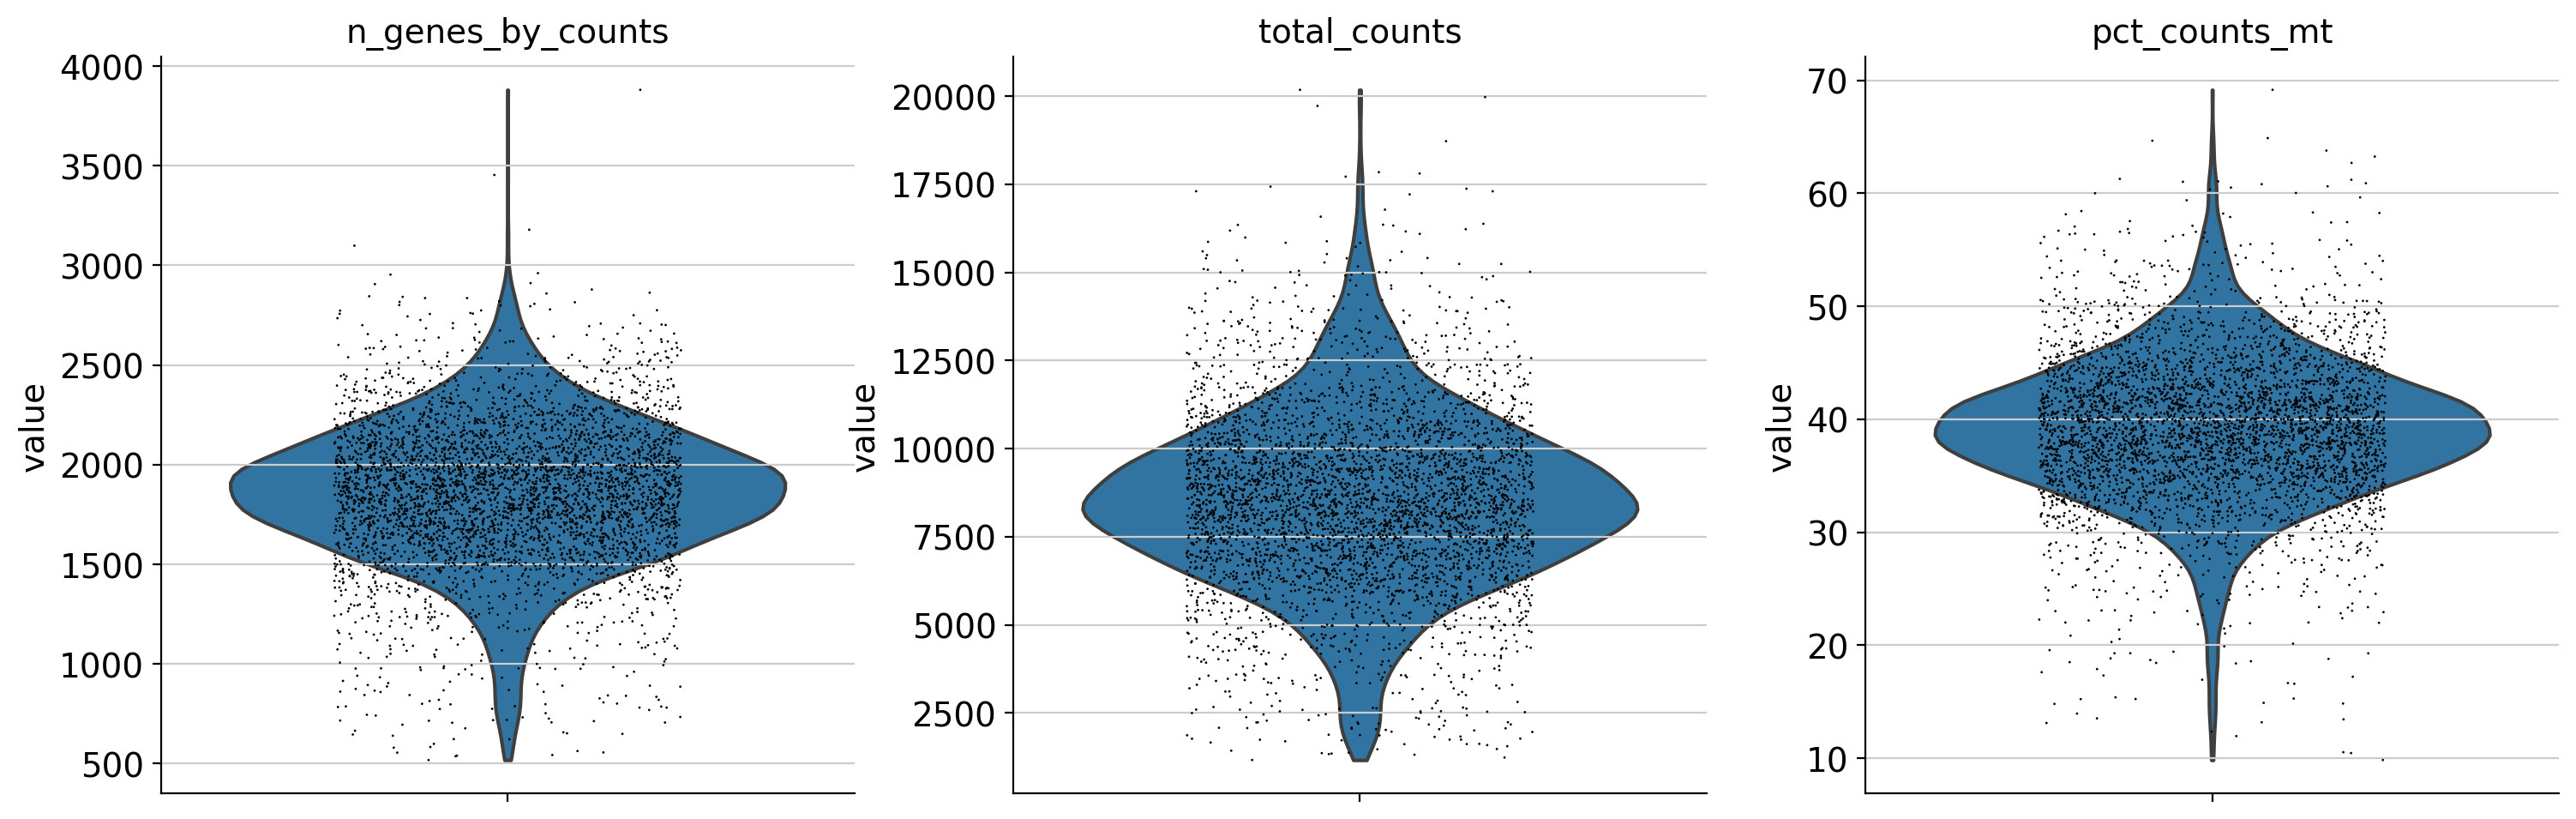

AnnData object with n_obs × n_vars = 4206 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
sc.pp.filter_cells(adata, min_counts = 500)
sc.pp.filter_cells(adata, min_genes = 500)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter = 0.25, multi_panel = True)
adata

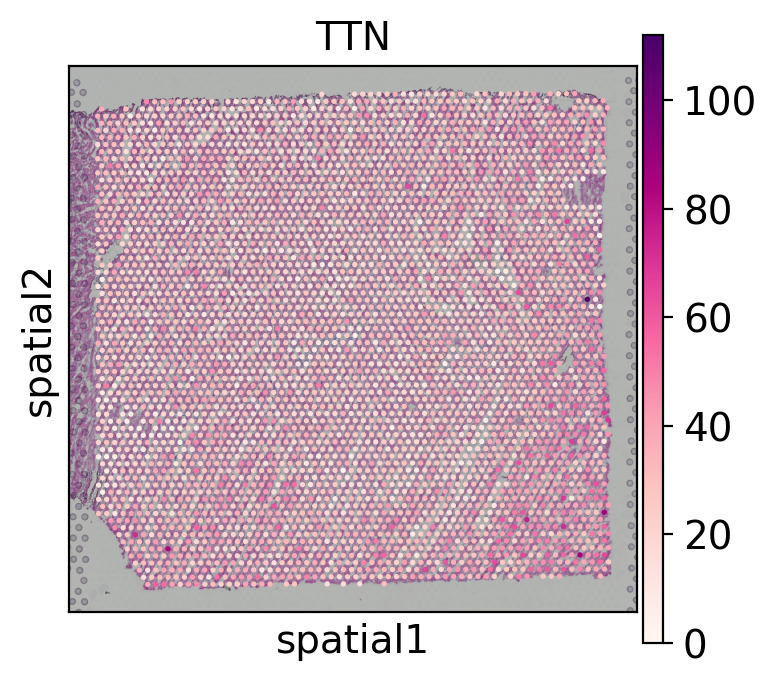

In [11]:
sc.pl.spatial(adata, img_key = "hires", color = ["TTN"])

- Subset so `scRNA-Seq` and `visium` have the same number of genes. 

In [12]:
sl_adata = adata.copy()
adata.obs["filter"] = [x in sl_adata.obs.index for x in adata.obs.index]

### Learn cell type specific gene expression based on the single-cell data

- Read in expression data. If this is to be run on CoLab, you can create a small subset of the data using ['geosketch'](https://github.com/brianhie/geosketch). 

In [13]:
sc_adata = sc.read_h5ad("/content/gdrive/My Drive/colab/data/scRNA-seq/visium_subsets/heart_LV_balanced_subset_raw_ctl210201.h5ad")
sc_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 37188 × 33538
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

In [14]:
sc.pp.filter_genes(sc_adata, min_counts = 10)
sc_adata

filtered out 8338 genes that are detected in less than 10 counts
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 37188 × 25200
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

- Create a combined label to correct for the single cell and single nuclei batches in the scRNA-Seq reference. 

In [15]:
sc_adata.obs['combined'] = [str(sc_adata.obs.loc[i,'donor']) + str(sc_adata.obs.loc[i,'cell_source']) for i in sc_adata.obs_names]
sc_adata

AnnData object with n_obs × n_vars = 37188 × 25200
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

- Remove mitochondrial genes

In [16]:
non_mito_genes_list = [name for name in sc_adata.var_names if not name.startswith('MT-')]
sc_adata = sc_adata[:, non_mito_genes_list]
sc_adata

View of AnnData object with n_obs × n_vars = 37188 × 25187
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

In [17]:
sc_adata.layers["counts"] = sc_adata.X.copy()
sc.pp.normalize_total(sc_adata, target_sum = 10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
normalizing counts per cell
    finished (0:00:00)


- Filter genes to be the same on the spatial data


In [18]:
intersect = np.intersect1d(sc_adata.var_names, adata.var_names)
sl_adata = sl_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


- Prepare the `scVI` model

In [19]:
scvi.data.setup_anndata(sc_adata, layer = "counts", labels_key = "cell_states", batch_key = 'combined')

INFO     Using batches from adata.obs["combined"]                               
INFO     Using labels from adata.obs["cell_states"]                             
INFO     Using data from adata.layers["counts"]                                 
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 37188 cells, 25187   
         vars, 52 batches, 69 labels, and 0 proteins. Also registered 0 extra   
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


- Train _scRNA-Seq_ model

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [08:48<00:00,  5.29s/it, loss=4.78e+03, v_num=1]


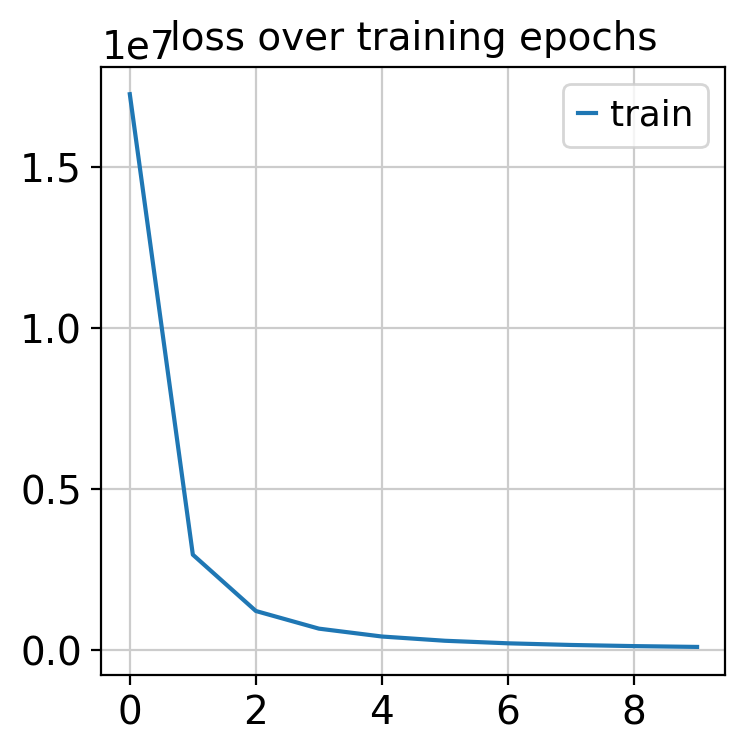

In [20]:
train = True
if train:
  model = RNAStereoscope(sc_adata)
  model.train(n_epochs = 100, frequency = None, vae_task_kwargs = {"lr":0.01}, train_size = 1.0)
  plt.plot(model.history["elbo_train"][:10], label = "train")
  plt.title("loss over training epochs")
  plt.legend()
  plt.show()
  model.save("scmodel", overwrite=True)
else:
  model = RNAStereoscope.load("scmodel", sc_adata)
  print("Loaded RNA model from file!")

In [21]:
params = model.get_params()
params[1]

array([-7.348801 , -7.7948103, -9.035393 , ..., -5.9476037, -5.9767103,
       -5.7806654], dtype=float32)

In [22]:
list(zip(sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"], params[0][np.where(sc_adata.var_names == "TREM2")[0][0],]))

[('Adip1', -5.0024624),
 ('Adip2', -3.282024),
 ('Adip3', -3.001839),
 ('Adip4', -3.2956135),
 ('B', -2.0500288),
 ('B_cells', -3.334108),
 ('B_follicular', -2.363819),
 ('B_memory', -3.3346548),
 ('B_plasma', -3.0704317),
 ('CD4+T_cytox', -4.487313),
 ('CD4+T_tem', -4.317549),
 ('CD4T', -4.4469433),
 ('CD4T_Tfh', -0.89198714),
 ('CD4T_Th1', -1.214657),
 ('CD4T_naive', -3.312945),
 ('CD4T_reg', -3.8175802),
 ('CD8+T_cytox', -4.6690617),
 ('CD8+T_tem', -3.9020946),
 ('CD8T', -4.868266),
 ('CD14+Mo', -4.158062),
 ('CD16+Mo', -2.1338177),
 ('DC', -4.6452928),
 ('DOCK4+MØ1', -4.3871455),
 ('DOCK4+MØ2', -4.251504),
 ('EC1_cap', -6.29932),
 ('EC2_cap', -6.7611327),
 ('EC3_cap', -6.4227777),
 ('EC4_immune', -6.393673),
 ('EC5_art', -6.8742332),
 ('EC6_ven', -6.7157264),
 ('EC7_atria', -3.7057192),
 ('EC8_ln', -4.297654),
 ('FB1', -6.5093536),
 ('FB2', -5.511817),
 ('FB3', -5.1223454),
 ('FB4', -6.6785903),
 ('FB5', -4.925155),
 ('IL17RA+Mo', -2.0112474),
 ('ILC', -3.57253),
 ('LYVE1+MØ1', -0.

### Infer proportion for spatial data

In [23]:
sl_adata.layers["counts"] = sl_adata.X.copy()
scvi.data.setup_anndata(sl_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch               
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.layers["counts"]                                 
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 4206 cells, 25187    
         vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra     
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


- Let's register the index as well, it's used in the inference 

In [24]:
sl_adata.obs["indices"] = np.arange(sl_adata.n_obs)
register_tensor_from_anndata(sl_adata, "ind_x", "obs", "indices")

- Train _Visium_ model. Although you could try to use the recommended 25K epochs, in our experience 10K are enough for this analysis. 

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10000/10000: 100%|██████████| 10000/10000 [1:18:44<00:00,  2.12it/s, loss=2.22e+07, v_num=1]


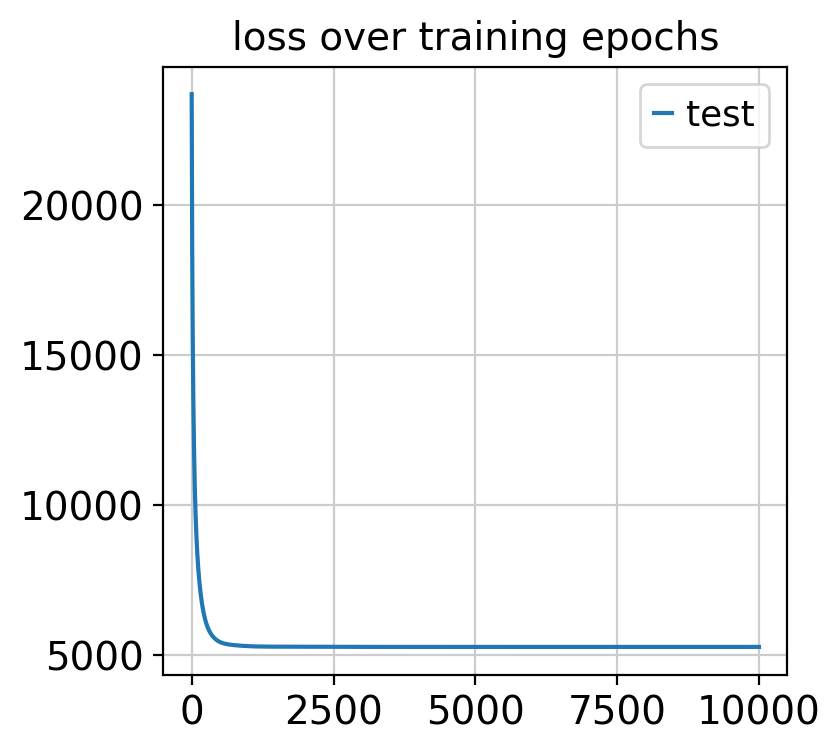

In [25]:
train=True
if train: 
  spatial_model = SpatialStereoscope(sl_adata, params)
  spatial_model.train(n_epochs = 10000, frequency = None, vae_task_kwargs = {"lr":0.01}, train_size = 1.0)
  plt.plot(spatial_model.history["elbo_train"], label = "test")
  plt.title("loss over training epochs")
  plt.legend()
  plt.show()
  spatial_model.save("stmodel", overwrite = True)
else:
  spatial_model = SpatialStereoscope.load("stmodel", sl_adata)
  print("Loaded Spatial model from file!")

### Deconvolve spots 

In [26]:
data = spatial_model.get_proportions()
columns = sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"]
sl_adata.obsm["deconvolution"] = pd.DataFrame(data = data, index = sl_adata.obs.index, columns = columns)

In [27]:
for ct in sl_adata.obsm["deconvolution"].columns:
    sl_adata.obs[ct] = sl_adata.obsm["deconvolution"][ct]

### Visualise populations

- _Et voliá_, we have now an `anndata` object that contains the inferred proportions on each Visium spot for each cell type in our single cell reference dataset. 

- In this example we can observe how nicely the arterial endotehlial cells (EC5_art) and the venous endothelial cells (EC6_ven) are highlighted in the areas were we expect to see cardiac vessels based on the histology of the sample. 

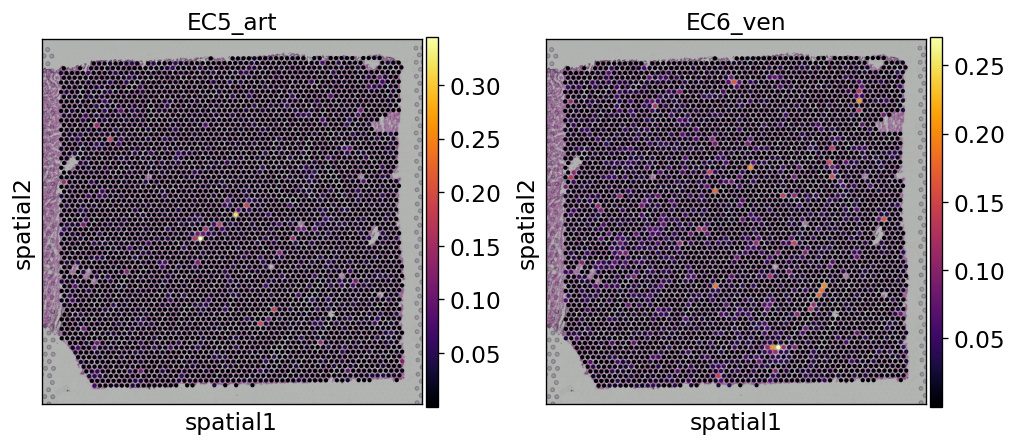

In [28]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu', dpi_save = 200, vector_friendly = True, format = 'svg')
sc.pl.spatial(sl_adata, img_key = "hires", color = ["EC5_art", "EC6_ven"], size = 1.2, color_map = 'inferno')